In [1]:
import pandas as pd
import numpy as np
import uuid
import geopandas as gd
import matplotlib.pyplot as plt

In [2]:
def order_with_replacement(n, k):
    """
    Returns the probability calculation for an ordered list with replacement. 
    Where n is the total number of elements, and k is the samples from the population.
    
    Args:
        n: int, total number of elements
        k: int, sample size
        
    Returns:
        float, calculation of: 1 - [n x (n - 1) x ... x (n - k + 1)] / [n^k]
    """
    p = 1
    for i in range(k):
        p *= (n - i)
    return 1 - p / (n**k) # exponential in Python is n**k

n = 365
k = range(20, 26)
for i in k:
    print(F"For {i} people, probability of any two having a birthday is {order_with_replacement(n, i):.2f}")

For 20 people, probability of any two having a birthday is 0.41
For 21 people, probability of any two having a birthday is 0.44
For 22 people, probability of any two having a birthday is 0.48
For 23 people, probability of any two having a birthday is 0.51
For 24 people, probability of any two having a birthday is 0.54
For 25 people, probability of any two having a birthday is 0.57


In [3]:
n = 365
k = 25
p = 1 - ((n - 1)/n)**(k - 1)
print(F"Probability that {k-1} people share a birth day with one specific person is {p:.2f}")

Probability that 24 people share a birth day with one specific person is 0.06


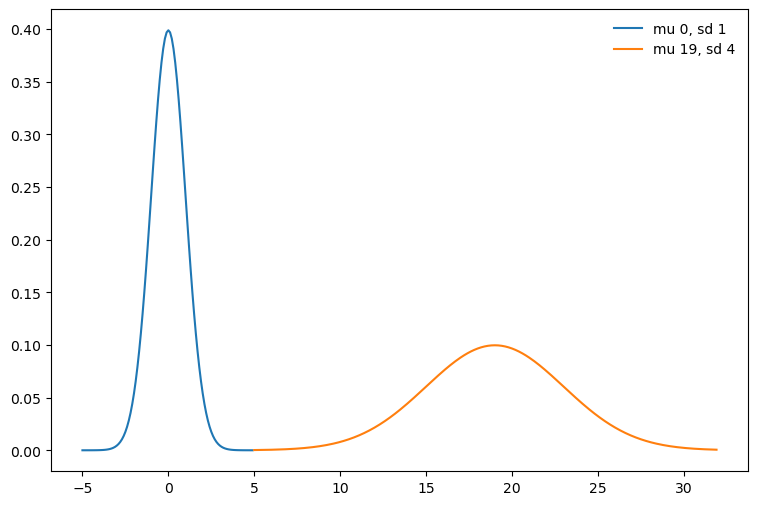

In [1]:
# A demonstration of differences in mean and standard deviation
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import numpy as np

# 1st
mu_1 = 0.0
sd_1 = 1.0
x_1 = np.arange(-5, 5, 0.1)
y_1 = norm.pdf(x_1, mu_1, sd_1)
# 2nd
mu_2 = 19.0
sd_2 = 4.0
x_2 = np.arange(5, 32, 0.1)
y_2 = norm.pdf(x_2, mu_2, sd_2)
# Draw the chart
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x_1,y_1, color="C0", label="mu 0, sd 1")
ax.plot(x_2,y_2, color="C1", label="mu 19, sd 4")
ax.legend(loc="best", frameon=False)
plt.show()

## patient data

In [9]:
df = pd.read_csv(r'path\patient-data-anonymisation-exercise.csv')
df[df["PATIENT_ID"] == "71ba0469-f0cc-4177-ac70-ea07cb01c8b8"]
# Specify columns for removal
suppression = ["SSN", "DRIVERS", "PASSPORT", "FIRST", "LAST", "MAIDEN", "ADDRESS", "ZIP"]
# And drop them
df.drop(suppression, axis=1, inplace=True)


sigma = 0.001 # standard deviation, i.e. the degree of variation from the original data we allow
mu = 1 # the original data, considered the `mean`

np.random.normal(mu, sigma)

1.0010462893897945

In [10]:
from collections import defaultdict

class Pseudonymise:
    
    def __init__(self, sigma=0.001):
        # Initialise a defaultdict, this creates a default dictionary item if it doesn't exist
        # We use this to ensure we maintain data integrity while still randomising
        # http://ikigomu.com/?p=28
        self.sigma = sigma
        self.mu = 0 # we want a deviation from the true point
        # Pseudo-patient dict
        self.pp = defaultdict(lambda: {"uuid":str(uuid.uuid4()),
                                       "lat": np.random.normal(self.mu, self.sigma),
                                       "lon": np.random.normal(self.mu, self.sigma)
                                      })
        
    def create_data(self, identities):
        """
        For each unique identity produce a unique UUID, and a Gaussian randomised `LAT` and `LON`.

        Paramaters
        ----------
        identities: list of strings

        Returns
        -------
        dict
            Each dict entry contains a record containing a "uuid" and modifier for "lat" and "lon"
        """
        for _id in identities:
            self.pp[_id]
        return self.pp
    
    def redact(self, row):
        """
        For a given row in a dataframe, return the pseudonymised version of "PATIENT_ID", "LAT", "LON".
        
        Parameters:
        row: DataFrame row
        
        Returns:
        DataFrame slice of row
        """
        return [
            self.pp[row["PATIENT_ID"]]["uuid"],
            row["LAT"] + self.pp[row["PATIENT_ID"]]["lat"],
            row["LON"] + self.pp[row["PATIENT_ID"]]["lon"],
        ]

p = Pseudonymise()
pp_data = p.create_data(df["PATIENT_ID"])
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
fields = ["PATIENT_ID", "LAT", "LON"]
df[fields] = df[fields].apply(p.redact, axis=1, result_type="expand")

<AxesSubplot:>

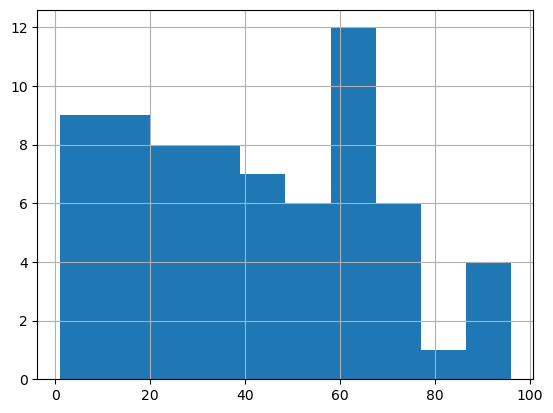

In [39]:
# Create a copy of the source data since aggregations are destructive
dfa = df.copy()
# Convert the date fields to pandas dates
for c in ["START", "STOP", "BIRTHDATE", "DEATHDATE"]:
    dfa[c] = dfa[c].apply(lambda x: pd.to_datetime(x, errors="coerce", dayfirst=True).date())
# Filter for the final medical treatment for all deceased patients
dfa = dfa[dfa.STOP==dfa.DEATHDATE]
dfa.sort_values(by="STOP", inplace=True)
dfa.drop_duplicates(subset="PATIENT_ID", keep="last", inplace=True)
# Create the DEATHAGE 
# This is a VERY approximate age at death calculation
dfa["DEATHAGE"] = dfa.DEATHDATE.apply(lambda x: x.year) - dfa.BIRTHDATE.apply(lambda x: x.year)
# And draw the DEATHAGE distribution, divided into n bins
dfa["DEATHAGE"].hist(bins=10)

## EXERCISE

In [110]:
# create range column
dfa['DEATHAGE_range'] = ""

# deathage classes - 10 years 
conditions = [
    (dfa['DEATHAGE'] <= 10),
    (dfa['DEATHAGE'] > 10) & (dfa['DEATHAGE'] <= 20),
    (dfa['DEATHAGE'] > 20) & (dfa['DEATHAGE'] <= 30),
    (dfa['DEATHAGE'] > 30) & (dfa['DEATHAGE'] <= 40),
    (dfa['DEATHAGE'] > 40) & (dfa['DEATHAGE'] <= 50),
    (dfa['DEATHAGE'] > 50) & (dfa['DEATHAGE'] <= 60),
    (dfa['DEATHAGE'] > 60) & (dfa['DEATHAGE'] <= 70),
    (dfa['DEATHAGE'] > 70) & (dfa['DEATHAGE'] <= 80),
    (dfa['DEATHAGE'] > 80) & (dfa['DEATHAGE'] <= 90),
    (dfa['DEATHAGE'] > 90)
]
values = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-96']
dfa['DEATHAGE_range'] = np.select(conditions, values)
df_range = dfa.set_index('DEATHAGE_range')

# calculating statistics
df_count = dfa.groupby('DEATHAGE_range', as_index=False)['DESCRIPTION'].nunique().rename(columns={'DESCRIPTION': 'Unique_description'}).set_index('DEATHAGE_range')
df_mean = dfa.groupby('DEATHAGE_range', as_index=False)['TOTAL_CLAIM_COST'].mean().rename(columns={'TOTAL_CLAIM_COST': 'Mean_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')
df_total = dfa.groupby('DEATHAGE_range', as_index=False)['TOTAL_CLAIM_COST'].sum().rename(columns={'TOTAL_CLAIM_COST': 'Sum_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')

# merge dataframes
dfs = [df_count,df_mean,df_total,df_range]

df_final = dfs[0].join(dfs[1:])
df_final.sort_values(by=['DEATHAGE'])

,Unique_description,Mean_TOTAL_CLAIM_COST,Sum_TOTAL_CLAIM_COST,PATIENT_ID,START,STOP,ENCOUNTERCLASS,DESCRIPTION,TOTAL_CLAIM_COST,PAYER_COVERAGE,...,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,LAT,LON,DEATHAGE
DEATHAGE_range,,,,,,,,,,,,,,,,,,,,,
1-10,2,129.16,1162.44,4132600a-595d-4e0a-8024-12cbf70eeda7,2019-05-15,2019-05-15,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Sturbridge Massachusetts US,Salem,Massachusetts,Essex County,42.517482,-70.908838,1
1-10,2,129.16,1162.44,7bad6517-a9f8-44db-a04d-df99a2870bae,2005-08-19,2005-08-19,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Milford Massachusetts US,Quincy,Massachusetts,Norfolk County,42.240908,-71.058369,1
1-10,2,129.16,1162.44,c7161a4b-f657-4973-9358-93c5207a876d,1976-11-11,1976-11-11,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Harwich Massachusetts US,Leicester,Massachusetts,Worcester County,42.206256,-71.872840,1
1-10,2,129.16,1162.44,7eba1d84-235c-44f7-835a-1603b41e6c6c,1983-11-07,1983-11-07,wellness,Death Certification,129.16,0.00,...,white,hispanic,F,Lima Lima Province PE,Waltham,Massachusetts,Middlesex County,42.322327,-71.190468,1
1-10,2,129.16,1162.44,37deb85c-2253-4125-a51b-8b72faac808a,2010-01-10,2010-01-10,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Boston Massachusetts US,Lynn,Massachusetts,Essex County,42.432163,-70.975880,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71-80,3,129.16,645.80,76c78542-bdeb-4aad-a332-02a4eaf3977a,1991-06-02,1991-06-02,emergency,Stroke,129.16,89.16,...,white,nonhispanic,M,Maynard Massachusetts US,Worcester,Massachusetts,Worcester County,42.242806,-71.817823,77
81-90,1,129.16,129.16,caf5fc91-038e-4d0d-b42b-39e02fb14171,2013-03-12,2013-03-12,emergency,Stroke,129.16,89.16,...,white,nonhispanic,F,Boston Massachusetts US,West Springfield,Massachusetts,Hampden County,42.152936,-72.660688,90
91-96,3,129.16,387.48,c56a5c99-17c3-40e4-bc9c-4bb3cac0738b,2013-08-20,2013-08-20,emergency,Stroke,129.16,89.16,...,asian,hispanic,F,Lima Lima Province PE,Cambridge,Massachusetts,Middlesex County,42.417492,-71.128393,91
